In [348]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [349]:
country_to_predict="Sudan"

**ARIMA**


In [350]:
df=pd.read_excel('test_arima.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
df.index.freq = 'YS'
df.head()

,Year,Value,Country
294,1970-01-01,52.234,Sudan
295,1971-01-01,52.583,Sudan
296,1972-01-01,52.901,Sudan
297,1973-01-01,53.184,Sudan
298,1974-01-01,53.430,Sudan


In [351]:
del df["Country"]

In [352]:
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.head()
df.index.freq = 'YS'

In [353]:
train_df = df[:len(df)-6]
test_df = df[len(df)-6:]

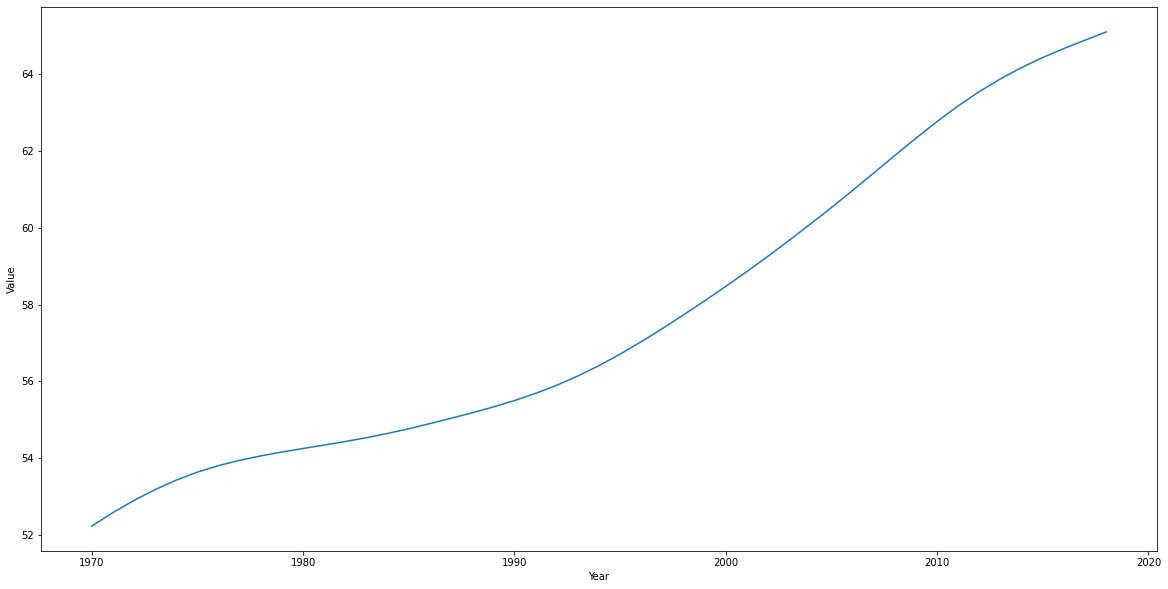

In [354]:
plt.figure(figsize=(20,10))
plt.xlabel("Year")
plt.ylabel("Value")
plt.plot(df)

In [355]:
rolmean=train_df.rolling(window=6).mean()
rolstd=train_df.rolling(window=6).std()
print(rolmean.head(15))
print(rolstd.head(15))

                Value
Year                 
1970-01-01        NaN
1971-01-01        NaN
1972-01-01        NaN
1973-01-01        NaN
1974-01-01        NaN
1975-01-01  52.995000
1976-01-01  53.257167
1977-01-01  53.484333
1978-01-01  53.677667
1979-01-01  53.840500
1980-01-01  53.977667
1981-01-01  54.095000
1982-01-01  54.199667
1983-01-01  54.297667
1984-01-01  54.395000
               Value
Year                
1970-01-01       NaN
1971-01-01       NaN
1972-01-01       NaN
1973-01-01       NaN
1974-01-01       NaN
1975-01-01  0.528412
1976-01-01  0.461288
1977-01-01  0.393521
1978-01-01  0.329331
1979-01-01  0.273170
1980-01-01  0.228852
1981-01-01  0.198308
1982-01-01  0.180862
1983-01-01  0.175136
1984-01-01  0.179527


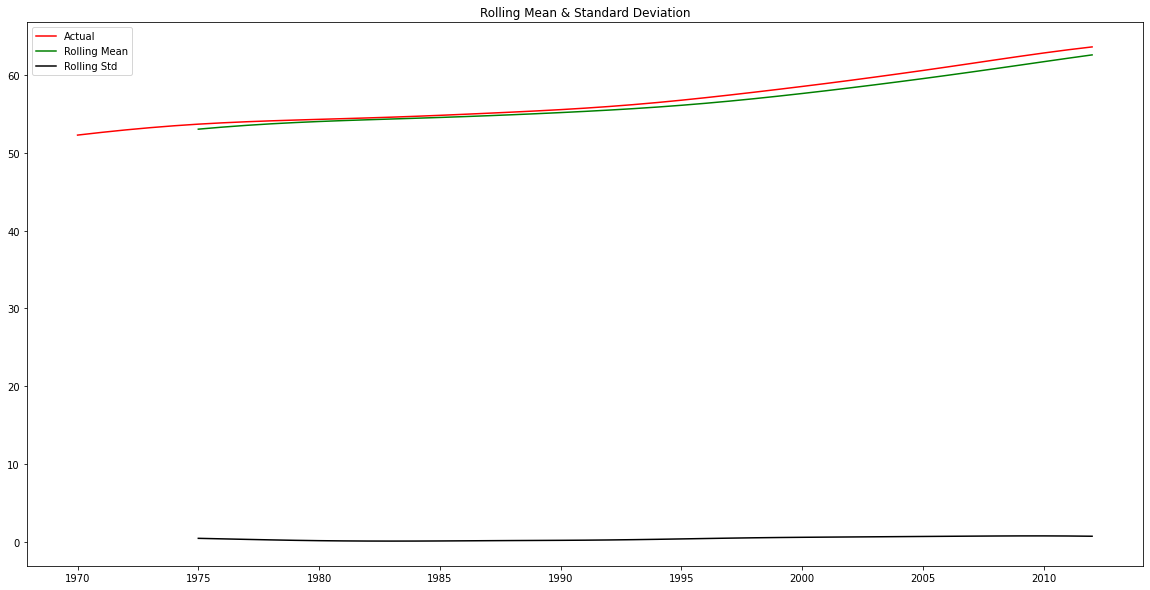

In [356]:
plt.figure(figsize=(20,10))
actual=plt.plot(train_df, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [357]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(train_df['Value'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic          -2.220536
p-value                  0.198877
Lags Used               10.000000
No. of Obs              32.000000
Critical Value (1%)     -3.653520
Critical Value (5%)     -2.957219
Critical Value (10%)    -2.617588
dtype: float64


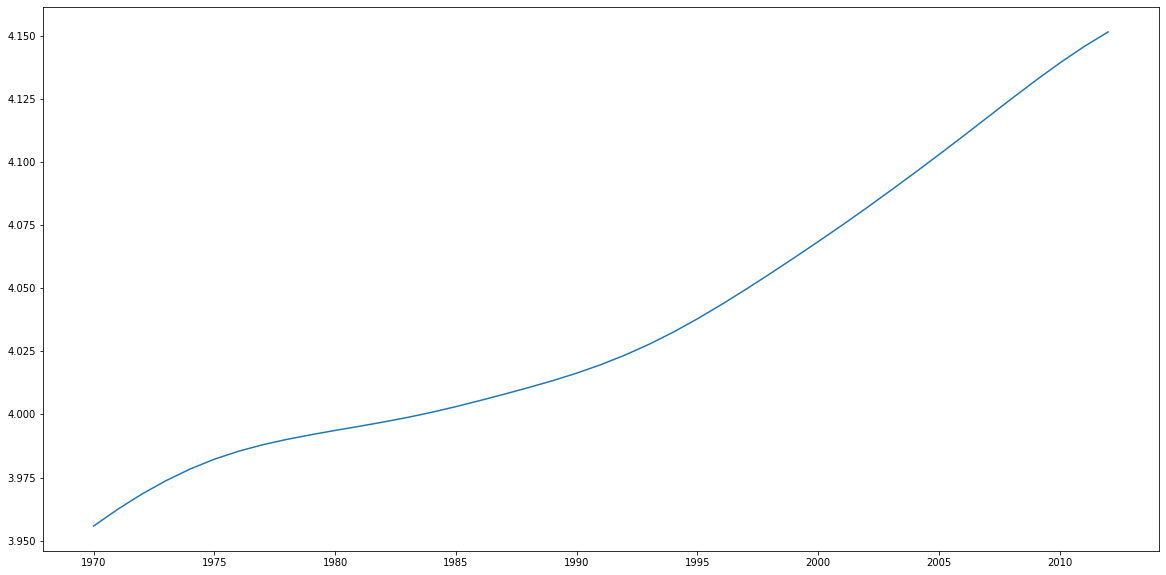

In [358]:
plt.figure(figsize=(20,10))
df_log=np.log(train_df)
plt.plot(df_log)

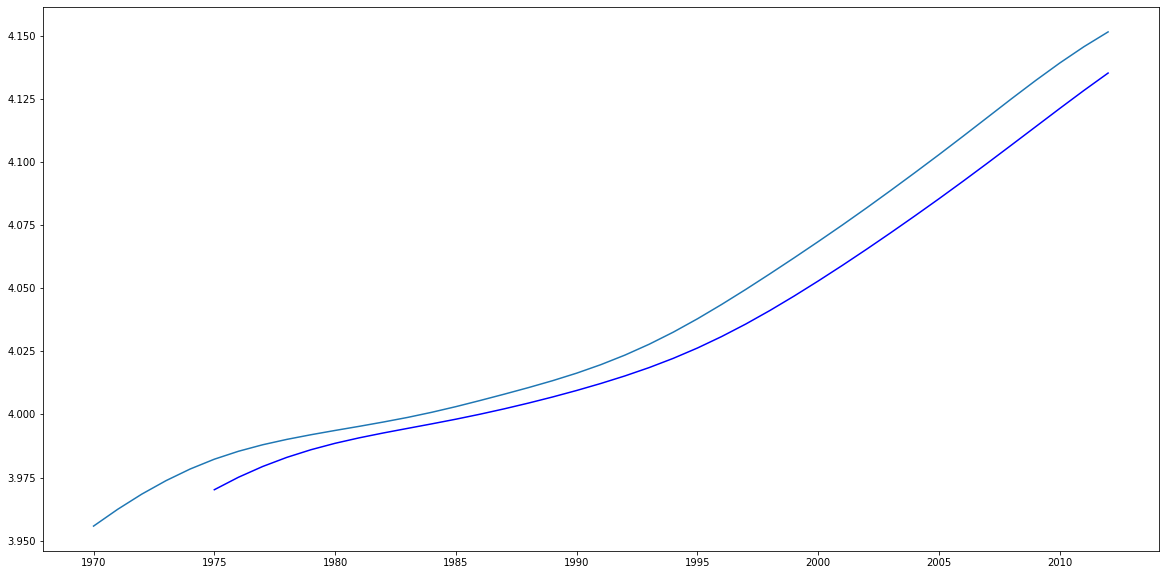

In [359]:
plt.figure(figsize=(20,10))
MAvg=df_log.rolling(window=6).mean()
MStd=df_log.rolling(window=6).std()
plt.plot(df_log)
plt.plot(MAvg, color='blue')

In [360]:
df_log_diff=df_log-MAvg
df_log_diff.head(12)

,Value
Year,
1970-01-01,NaN
1971-01-01,NaN
1972-01-01,NaN
1973-01-01,NaN
1974-01-01,NaN
1975-01-01,0.012102
1976-01-01,0.010302
1977-01-01,0.008617
1978-01-01,0.007132


In [361]:
df_log_diff=df_log_diff.dropna()
df_log_diff.head()

,Value
Year,
1975-01-01,0.012102
1976-01-01,0.010302
1977-01-01,0.008617
1978-01-01,0.007132
1979-01-01,0.005946


In [362]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=6).mean()
    rolstd=timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['Value'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

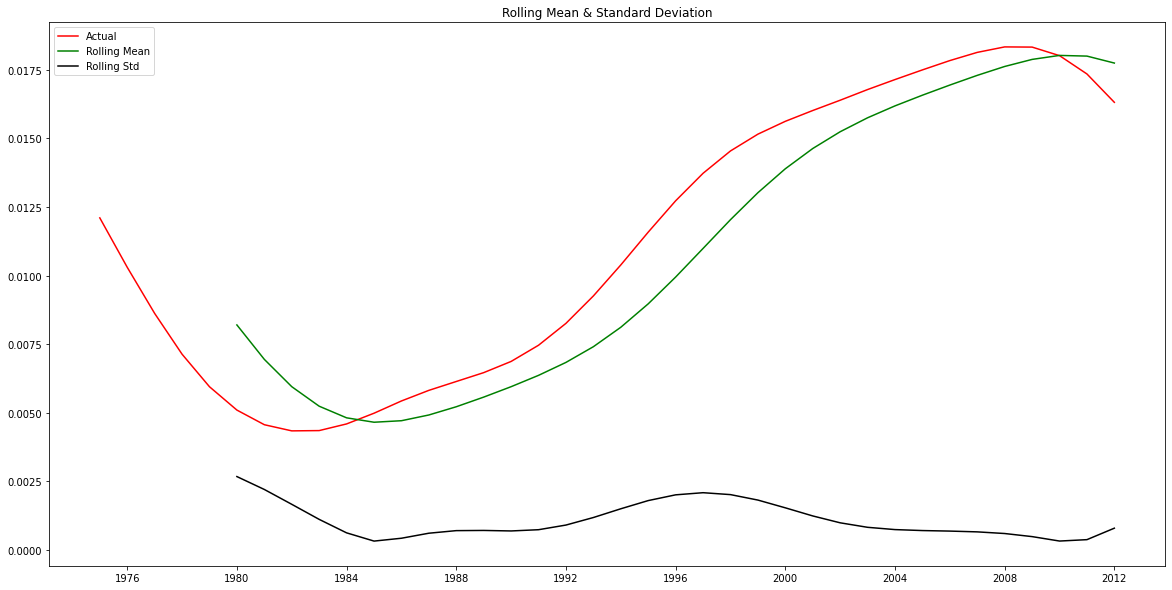

Dickey-Fuller Test: 
Test Statistic          -3.577128
p-value                  0.006214
Lags Used                7.000000
No. of Obs              30.000000
Critical Value (1%)     -3.669920
Critical Value (5%)     -2.964071
Critical Value (10%)    -2.621171
dtype: float64


In [363]:
stationarity(df_log_diff)

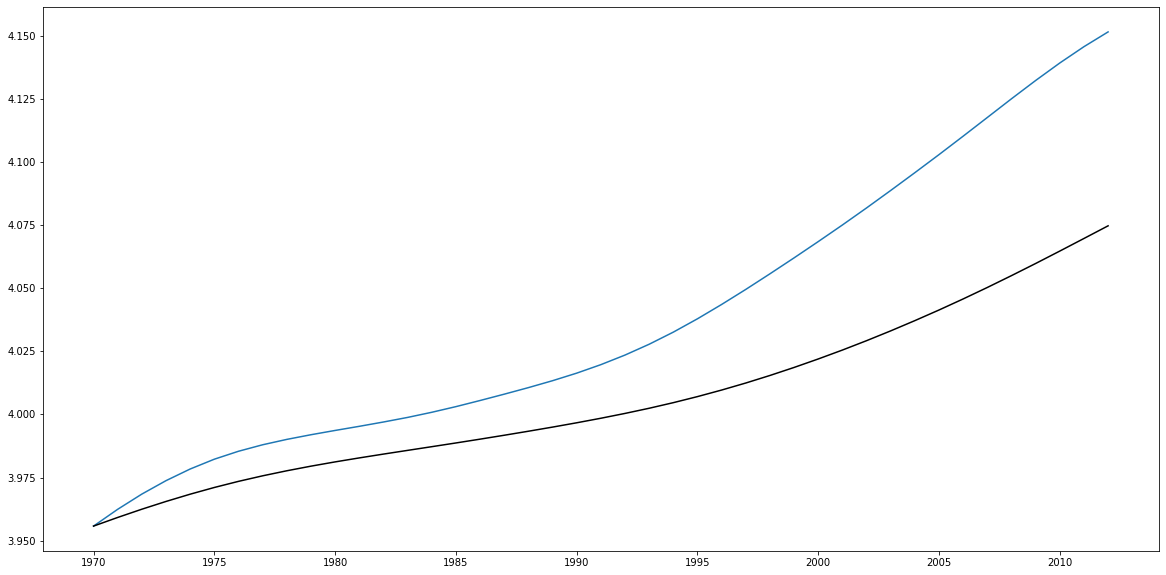

In [364]:
plt.figure(figsize=(20,10))
exp_df=df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_log)
plt.plot(exp_df, color='black')

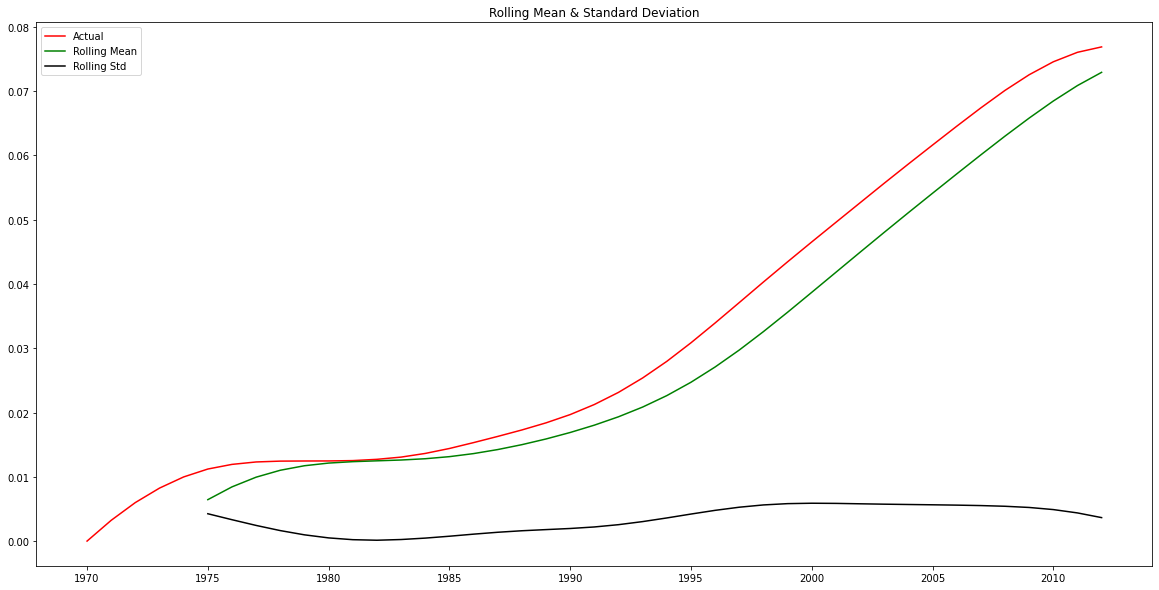

Dickey-Fuller Test: 
Test Statistic          -3.000263
p-value                  0.034870
Lags Used               10.000000
No. of Obs              32.000000
Critical Value (1%)     -3.653520
Critical Value (5%)     -2.957219
Critical Value (10%)    -2.617588
dtype: float64


In [365]:
exp_df_diff=df_log-exp_df
stationarity(exp_df_diff)

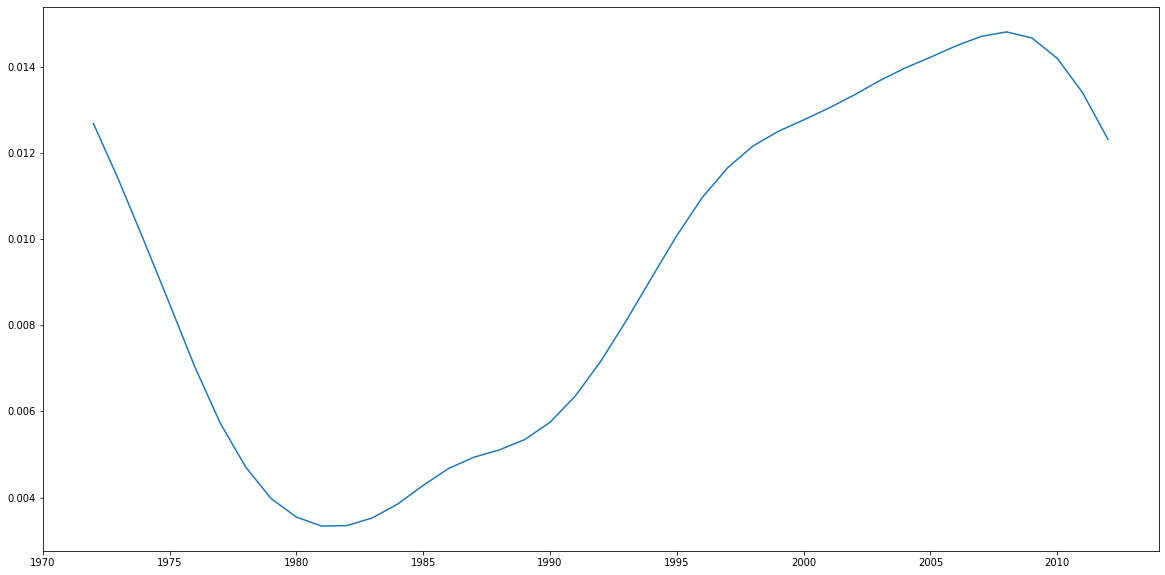

In [366]:
plt.figure(figsize=(20,10))
df_shift=df_log-df_log.shift(2)
plt.plot(df_shift)

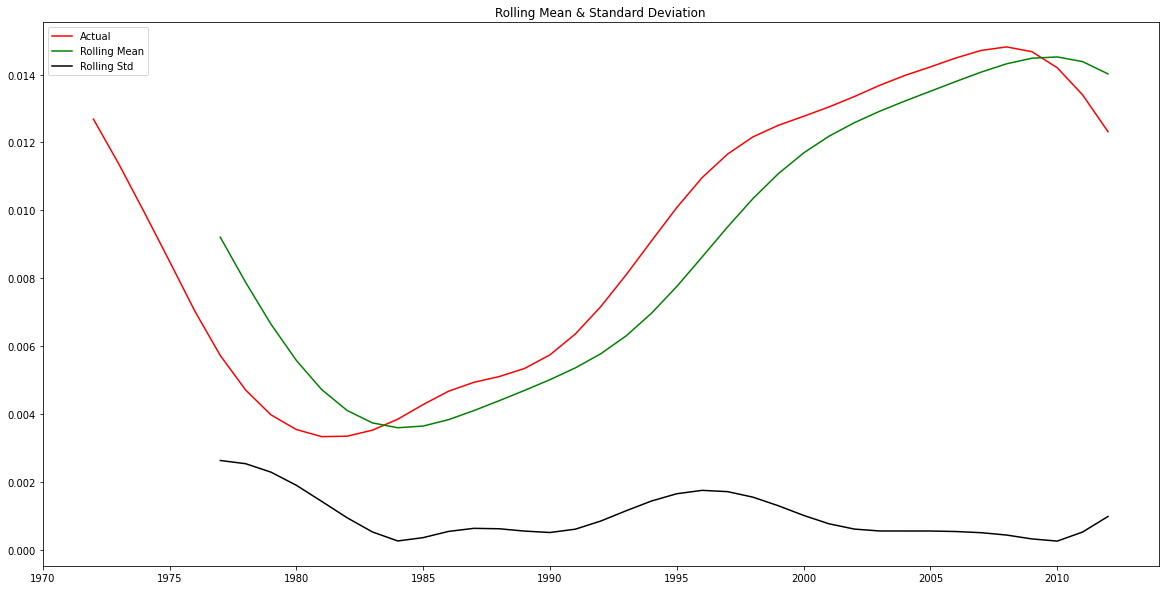

Dickey-Fuller Test: 
Test Statistic          -2.666331
p-value                  0.080048
Lags Used                3.000000
No. of Obs              37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
dtype: float64


In [367]:
df_shift=df_shift.dropna()
stationarity(df_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

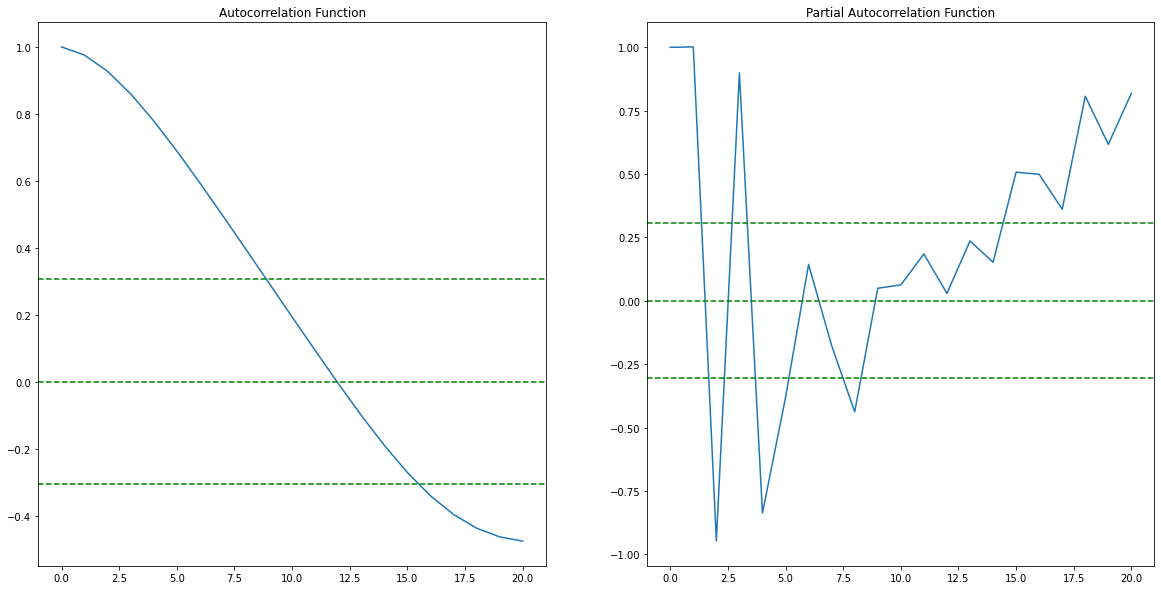

In [368]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(df_log_diff, nlags=20)
lag_pacf=pacf(df_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

plotting ARIMA model


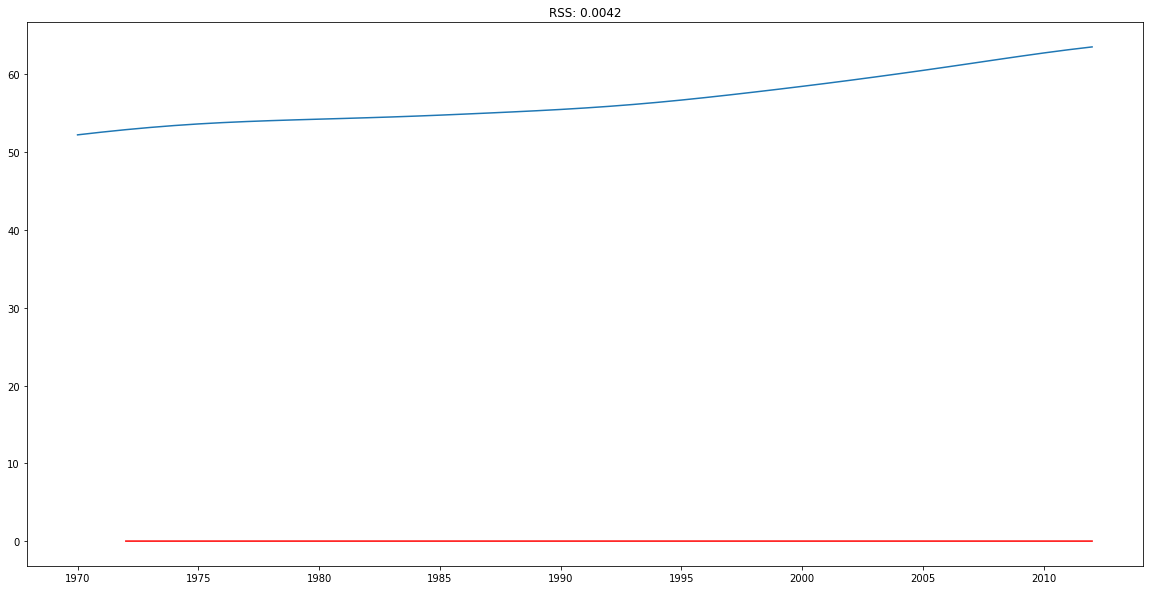

In [388]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(df_log, order=(4,2,0))
results=model.fit(disp=-1)
plt.plot(train_df)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-df_shift['Value'])**2))
print('plotting ARIMA model')

In [389]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Year
1972-01-01   -0.000158
1973-01-01   -0.000618
1974-01-01   -0.000722
1975-01-01   -0.000720
1976-01-01   -0.000705
Freq: AS-JAN, dtype: float64


In [390]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Year
1972-01-01   -0.000158
1973-01-01   -0.000776
1974-01-01   -0.001498
1975-01-01   -0.002218
1976-01-01   -0.002922
Freq: AS-JAN, dtype: float64


In [391]:
predictions_log=pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
#predictions_log.head()

In [392]:
arima_pred = results.predict(start = len(train_df), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred=np.exp(arima_pred)
test_df['ARIMA_Predictions'] = arima_pred
#arima_pred


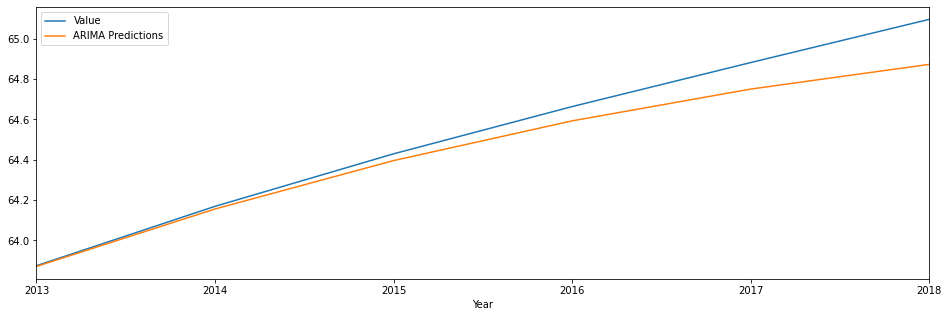

In [393]:
test_df['Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [394]:
arima_rmse_error = rmse(test_df['Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 0.012203584306963541
RMSE Error: 0.11046983437555948
Mean: 57.714693877551014


In [395]:
output=results.forecast(13)
output1=np.exp(output[0])
output1
outputs = pd.DataFrame(output1[-7:])
outputs.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs["Country"]=country_to_predict
outputs

,0,Country
2019,64.964168,Sudan
2020,65.030303,Sudan
2021,65.074552,Sudan
2022,65.100303,Sudan
2023,65.110268,Sudan
2024,65.106494,Sudan
2025,65.090439,Sudan


In [396]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_arima.xlsx')
writer = pandas.ExcelWriter('test_arima.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [397]:
test_df

,Value,ARIMA_Predictions
Year,,
2013-01-01,63.875,63.871286
2014-01-01,64.169,64.155814
2015-01-01,64.429,64.395496
2016-01-01,64.663,64.592280
2017-01-01,64.881,64.749712
2018-01-01,65.095,64.872125


**LSTM**

In [518]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [519]:
df=pd.read_excel('test_lstm.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.index.freq = 'YS'
train_df_lstm = df[:len(df)-6]
test_df_lstm = df[len(df)-6:]
df.tail()

,Value
Year,
2014-01-01,64.169
2015-01-01,64.429
2016-01-01,64.663
2017-01-01,64.881
2018-01-01,65.095


In [520]:
scaler.fit(train_df)
scaled_train_data = scaler.transform(train_df_lstm)
scaled_test_data = scaler.transform(test_df_lstm)

In [521]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [522]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(256, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 256)               264192    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [523]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
31/31 [==============================] - 0s 14ms/step - loss: 0.1091
Epoch 2/20
31/31 [==============================] - 0s 15ms/step - loss: 0.0038
Epoch 3/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0041
Epoch 4/20
31/31 [==============================] - 0s 15ms/step - loss: 0.0027
Epoch 5/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0019
Epoch 6/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0041
Epoch 7/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0025
Epoch 8/20
31/31 [==============================] - 0s 14ms/step - loss: 9.9031e-04
Epoch 9/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0013
Epoch 10/20
31/31 [==============================] - 0s 14ms/step - loss: 0.0013
Epoch 11/20
31/31 [==============================] - 0s 14ms/step - loss: 9.2984e-04
Epoch 12/20
31/31 [==============================] - 0s 13ms/step - loss: 0.0022
Epoch 13/20
31/31 [==========

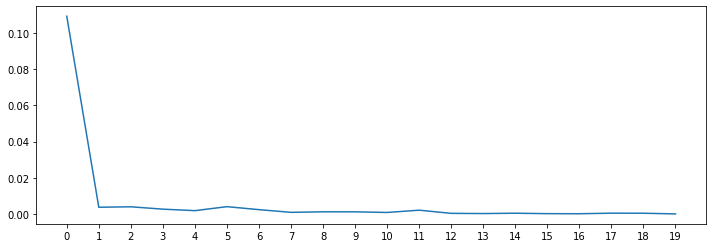

In [524]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [525]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [526]:
lstm_predictions_scaled

[array([1.0442772], dtype=float32),
 array([1.0890886], dtype=float32),
 array([1.1350513], dtype=float32),
 array([1.182217], dtype=float32),
 array([1.2306567], dtype=float32),
 array([1.2804338], dtype=float32)]

In [527]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [528]:
lstm_predictions

array([[64.04268648],
       [64.54941343],
       [65.06915954],
       [65.60250986],
       [66.15026645],
       [66.71314512]])

In [529]:
test_df['LSTM_Predictions'] = lstm_predictions

In [530]:
test_df

,Value,ARIMA_Predictions,LSTM_Predictions
Year,,,
2013-01-01,63.875,63.871286,64.042686
2014-01-01,64.169,64.155814,64.549413
2015-01-01,64.429,64.395496,65.069160
2016-01-01,64.663,64.592280,65.602510
2017-01-01,64.881,64.749712,66.150266
2018-01-01,65.095,64.872125,66.713145


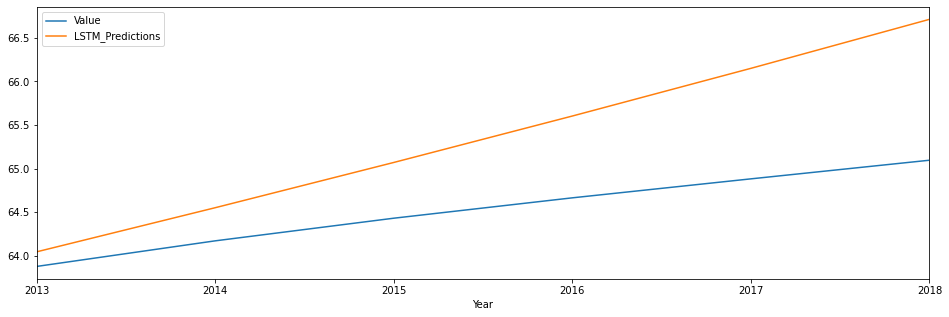

In [531]:
test_df['Value'].plot(figsize = (16,5), legend=True)
test_df['LSTM_Predictions'].plot(legend = True);

In [532]:
lstm_rmse_error = rmse(test_df['Value'], test_df["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 0.94912451321183
RMSE Error: 0.9742302157148638
Mean: 57.714693877551014


In [533]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)+6):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [534]:
lstm_predictions_scaled

[array([1.0442772], dtype=float32),
 array([1.0890886], dtype=float32),
 array([1.1350513], dtype=float32),
 array([1.182217], dtype=float32),
 array([1.2306567], dtype=float32),
 array([1.2804338], dtype=float32),
 array([1.331607], dtype=float32),
 array([1.3842573], dtype=float32),
 array([1.4384997], dtype=float32),
 array([1.4945574], dtype=float32),
 array([1.5527961], dtype=float32),
 array([1.6135746], dtype=float32)]

In [535]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [536]:
lstm_predictions

array([[64.04268648],
       [64.54941343],
       [65.06915954],
       [65.60250986],
       [66.15026645],
       [66.71314512],
       [67.29181178],
       [67.88718174],
       [68.50055448],
       [69.13445486],
       [69.79301859],
       [70.48030185]])

In [537]:
output2=lstm_predictions
outputs2 = pd.DataFrame(lstm_predictions[-7:])
outputs2.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs2["Country"]=country_to_predict
outputs2

,0,Country
2019,66.713145,Sudan
2020,67.291812,Sudan
2021,67.887182,Sudan
2022,68.500554,Sudan
2023,69.134455,Sudan
2024,69.793019,Sudan
2025,70.480302,Sudan


In [538]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_lstm.xlsx')
writer = pandas.ExcelWriter('test_lstm.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs2.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

**Prophet**

In [539]:
df = pd.read_excel('test_prophet.xlsx')
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df.head()
df_pr = df.copy()
#df = df.reset_index()
df_pr.columns = ['ds','y']
df_pr.tail()


,ds,y
338,2014,64.169
339,2015,64.429
340,2016,64.663
341,2017,64.881
342,2018,65.095


In [540]:
df_pr['ds'] = pd.to_datetime(df_pr['ds'],format="%Y")
df_pr.tail()

,ds,y
338,2014-01-01,64.169
339,2015-01-01,64.429
340,2016-01-01,64.663
341,2017-01-01,64.881
342,2018-01-01,65.095


In [541]:
train_data_pr = df_pr.iloc[:len(df)-6]
test_data_pr = df_pr.iloc[len(df)-6:]

In [542]:
from fbprophet import Prophet

In [543]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=6,freq='YS')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [544]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
44,2014-01-01,14.874377,64.440510,64.526908,14.831294,14.916383,49.610111,49.610111,49.610111,49.610111,49.610111,49.610111,0.0,0.0,0.0,64.484488
45,2015-01-01,15.311251,64.837323,65.005036,15.228644,15.396825,49.605581,49.605581,49.605581,49.605581,49.605581,49.605581,0.0,0.0,0.0,64.916833
46,2016-01-01,15.748125,65.215175,65.493908,15.619103,15.895739,49.599555,49.599555,49.599555,49.599555,49.599555,49.599555,0.0,0.0,0.0,65.347680
47,2017-01-01,16.186196,65.595807,65.983919,15.994928,16.377041,49.601471,49.601471,49.601471,49.601471,49.601471,49.601471,0.0,0.0,0.0,65.787667
48,2018-01-01,16.623070,65.987495,66.486201,16.372737,16.878326,49.610111,49.610111,49.610111,49.610111,49.610111,49.610111,0.0,0.0,0.0,66.233181


In [545]:
prophet_pred = pd.DataFrame({"Year" : prophet_pred[-6:]['ds'], "Pred" : prophet_pred[-6:]["yhat"]})

In [546]:
prophet_pred = prophet_pred.set_index("Year")

In [547]:
prophet_pred.index.freq = "YS"

In [548]:
prophet_pred

,Pred
Year,
2013-01-01,64.038975
2014-01-01,64.484488
2015-01-01,64.916833
2016-01-01,65.347680
2017-01-01,65.787667
2018-01-01,66.233181


In [549]:
test_df["Prophet_Predictions"] = prophet_pred['Pred'].values
test_df

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Year,,,,
2013-01-01,63.875,63.871286,64.042686,64.038975
2014-01-01,64.169,64.155814,64.549413,64.484488
2015-01-01,64.429,64.395496,65.069160,64.916833
2016-01-01,64.663,64.592280,65.602510,65.347680
2017-01-01,64.881,64.749712,66.150266,65.787667
2018-01-01,65.095,64.872125,66.713145,66.233181


In [550]:
import seaborn as sns

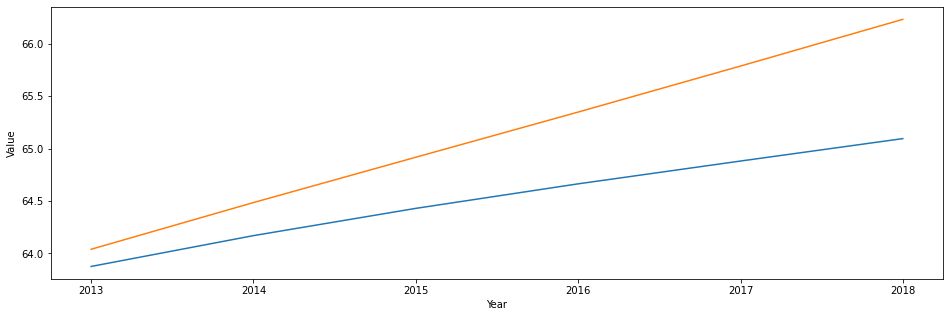

In [551]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_df.index, y=test_df["Value"])
sns.lineplot(x=test_df.index, y = test_df["Prophet_Predictions"]);

In [552]:
prophet_rmse_error = rmse(test_df['Value'], test_df["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 0.4917813188841553
RMSE Error: 0.7012712163522437
Mean: 57.714693877551014


In [553]:
future = m.make_future_dataframe(periods=13,freq = 'YS')
prophet_pred = m.predict(future)

In [554]:
#prophet_pred = pd.DataFrame({"Year" : prophet_pred[-11:]['ds'], "Pred" : prophet_pred[-11:]["yhat"]})
abc=prophet_pred[['ds', 'yhat']].tail(7)

In [555]:
abc.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
del abc['ds']
abc = abc.rename(columns={'yhat': 'Value'})
abc["Country"]=country_to_predict
abc

,Value,Country
2019,66.665525,Sudan
2020,67.096372,Sudan
2021,67.536360,Sudan
2022,67.981873,Sudan
2023,68.414217,Sudan
2024,68.845064,Sudan
2025,69.285052,Sudan


In [556]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_prophet.xlsx')
writer = pandas.ExcelWriter('test_prophet.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    abc.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [557]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

Mean: 64.51866666666666


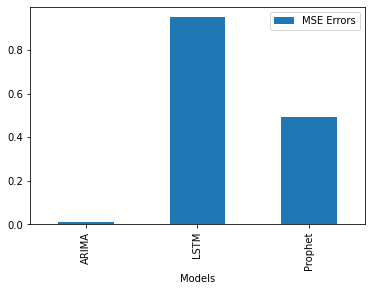

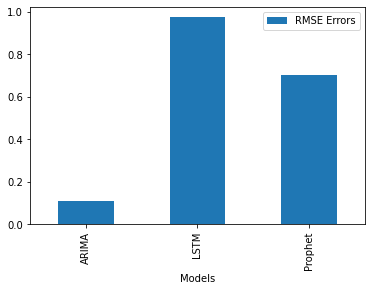

In [558]:
print(f"Mean: {test_df['Value'].mean()}")
errors
errors.plot(kind="bar",x="Models",y="MSE Errors")
errors.plot(kind="bar",x="Models",y="RMSE Errors")

In [559]:
errors["Country"]=country_to_predict
errors

,Models,RMSE Errors,MSE Errors,Country
0,ARIMA,0.110470,0.012204,Sudan
1,LSTM,0.974230,0.949125,Sudan
2,Prophet,0.701271,0.491781,Sudan


In [560]:
import pandas
from openpyxl import load_workbook

book = load_workbook('errors.xlsx')
writer = pandas.ExcelWriter('errors.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    errors.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =False,header= False)

writer.save()

In [561]:
output3=test_df
output3["Country"]=country_to_predict
output3.reset_index()
output3.index=['2013', '2014', '2015','2016', '2017', '2018']
output3

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions,Country
2013,63.875,63.871286,64.042686,64.038975,Sudan
2014,64.169,64.155814,64.549413,64.484488,Sudan
2015,64.429,64.395496,65.069160,64.916833,Sudan
2016,64.663,64.592280,65.602510,65.347680,Sudan
2017,64.881,64.749712,66.150266,65.787667,Sudan
2018,65.095,64.872125,66.713145,66.233181,Sudan


In [562]:
import pandas
from openpyxl import load_workbook

book = load_workbook('comparison.xlsx')
writer = pandas.ExcelWriter('comparison.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    output3.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =True,header= False)

writer.save()

<Figure size 1368x648 with 0 Axes>

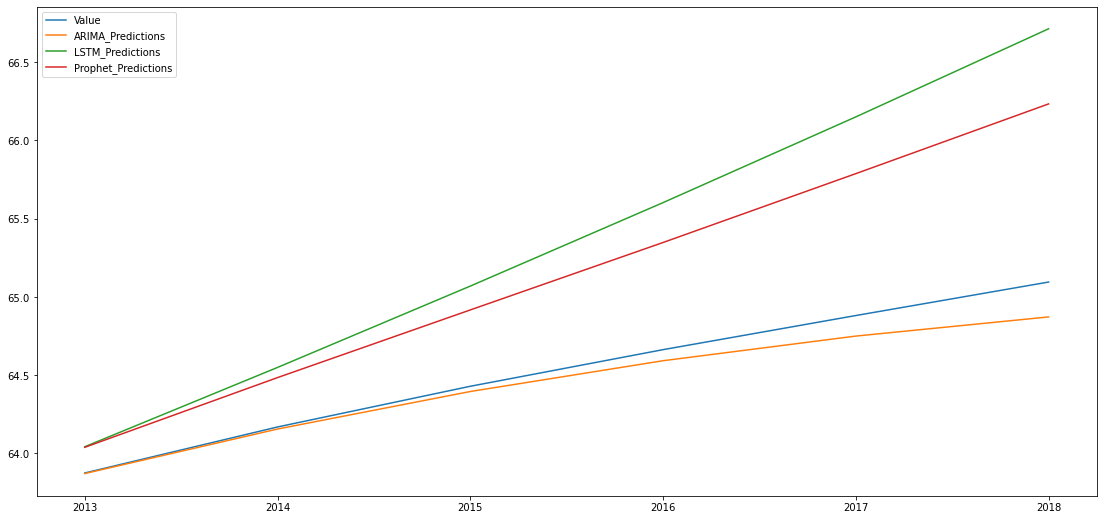

In [563]:
plt.figure(figsize=(19,9))
test_df.plot(figsize=(19,9))